# Classifying elliptic curves by complex multiplication

In [32]:
import pandas as pd
import numpy as np 
from sklearn.model_selection import train_test_split
from tqdm.notebook import *
from math import *
from livelossplot import PlotLosses
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn import tree
import matplotlib
from helpers import *

In [33]:
df = pd.read_csv("output/dataset_unnormalized.csv")

In [34]:
df.head()

,A2,A3,A5,A7,A11,A13,A17,A19,A23,A29,...,A953,A967,A971,A977,A983,A991,A997,CONDUCTOR,L1,CM
0,0.0,0.0,-2.0,-5.0,-4.0,4.0,-4.0,1.0,6.0,0.0,...,19.0,-17.0,10.0,8.0,-16.0,11.0,-10.0,344493.0,0.000000e+00,0.0
1,0.0,0.0,3.0,-1.0,0.0,0.0,0.0,-5.0,6.0,8.0,...,4.0,-32.0,-4.0,59.0,48.0,-16.0,55.0,377332.0,2.974117e+00,0.0
2,-1.0,0.0,0.0,-2.0,0.0,-1.0,0.0,-7.0,3.0,-6.0,...,41.0,40.0,-12.0,-12.0,-40.0,-26.0,-51.0,356235.0,2.201605e-19,0.0
3,1.0,1.0,0.0,0.0,3.0,-2.0,-5.0,4.0,-1.0,0.0,...,41.0,36.0,12.0,-5.0,14.0,16.0,62.0,215915.0,3.062639e+00,0.0
4,0.0,0.0,-2.0,0.0,3.0,-6.0,0.0,8.0,4.0,10.0,...,-36.0,-42.0,42.0,57.0,-36.0,50.0,-32.0,295806.0,1.896591e+00,0.0


In [47]:
L1_ONLY = True
SOPHIE_GERMAIN = False

In [48]:
if L1_ONLY:
    df = df[["L1","CM"]]
if not SOPHIE_GERMAIN:
    X = np.array(df)
    X = np.delete(X, len(X[0])-1, 1)
    Y = np.array(df["CM"])
    indexes = df.columns.values[:-1]
else:
    indexes=[]
    for x in df.columns.values:
        if x == "CM":
            continue
        if is_sg(int(x[1:])) or is_safe(int(x[1:])):
            indexes.append(x)
    X = np.array(df[indexes])
    Y = np.array(df["CM"])

In [49]:
X.shape

(5000, 1)

In [55]:
df["CM"]

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
4995    1.0
4996    1.0
4997    1.0
4998    1.0
4999    1.0
Name: CM, Length: 5000, dtype: float64

In [79]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, shuffle = True)
assert 0.4 < len(Y_train[Y_train==1])/len(Y_train) < 0.6, "Imbalanced train dataset"
assert 0.4 < len(Y_test[Y_test==1])/len(Y_test) < 0.6, "Imbalanced test dataset"

In [80]:
def ma_sampling(x: list, win = 28): # For pretty plots
    assert len(x)>win, "Window too large!"
    cur_sum = sum(x[:win])
    cur_pos = win - 1
    sampled = []
    for i in range(len(x)-win):
        sampled.append(cur_sum/win)
        cur_sum -= x[cur_pos-win]
        cur_pos += 1
        cur_sum += x[cur_pos]
    return sampled

In [81]:
def acc(X,Y):
    err_cnt = 0
    correct_cnt = 0
    for i in range(len(X)):
        x = torch.tensor(X[i], dtype=torch.double).float()
        y = Y[i]
        _y = model(x)
        if _y[0] > _y[1]:
            cls = 0
        else:
            cls = 1
        if round(y) != cls:
            err_cnt+=1
        else:
            correct_cnt+=1
    return correct_cnt/(correct_cnt+err_cnt)

## Neural network model

/usr/local/lib/python3.9/site-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


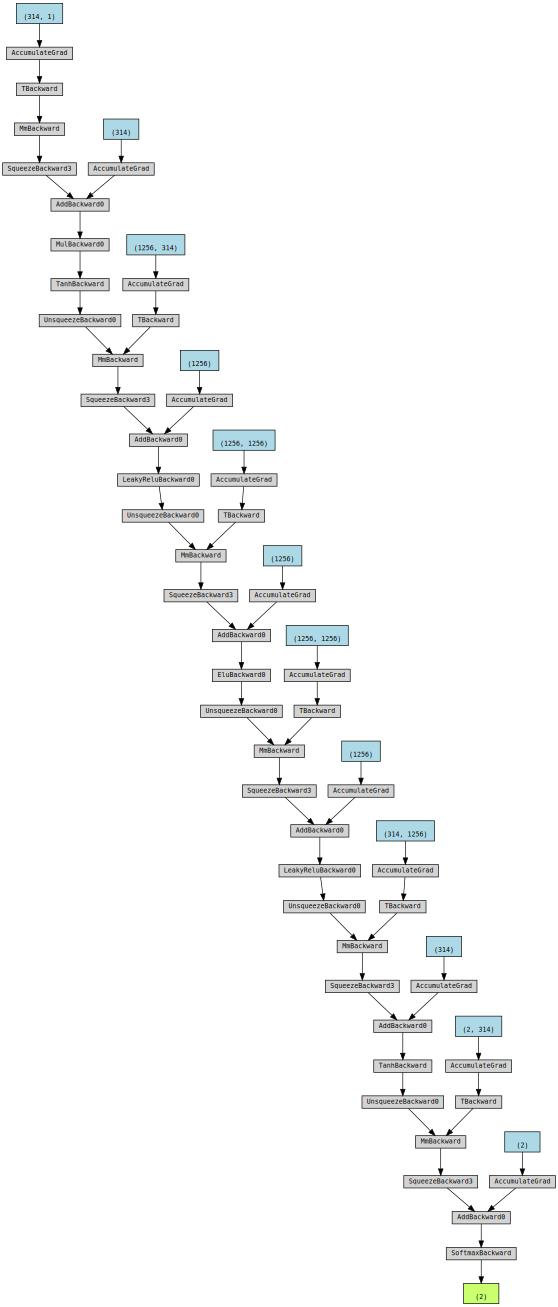

In [82]:
from torchviz import make_dot
DATA_SIZE = len(X[0])
N_EPOCHS = 2000
N_DISPLAY = 20
SAMPLE_SIZE = 100
A=314
k=4
model = nn.Sequential(
        nn.Linear(DATA_SIZE, A),
        nn.Dropout(0.1),
        nn.Tanh(),
        nn.Linear(A, k*A),
        nn.LeakyReLU(),
        nn.Linear(k*A, k*A),
        nn.ELU(),
        nn.Linear(k*A, k*A),
        nn.LeakyReLU(),
        nn.Linear(k*A, A),
        nn.Tanh(),
        nn.Linear(A, 2),
        nn.Softmax()
)
criterion = nn.CrossEntropyLoss() # The MOST inconvinient criterion ever!
optimizer = optim.SGD(model.parameters(), lr=0.01)
#print("Untrained accuracy(test): %.3f"%acc(X_test, Y_test))
#print("Untrained accuracy(train): %.3f"%acc(X_train, Y_train))
x = torch.tensor(X[0], dtype=torch.double).float()
y = model(x)
make_dot(y)

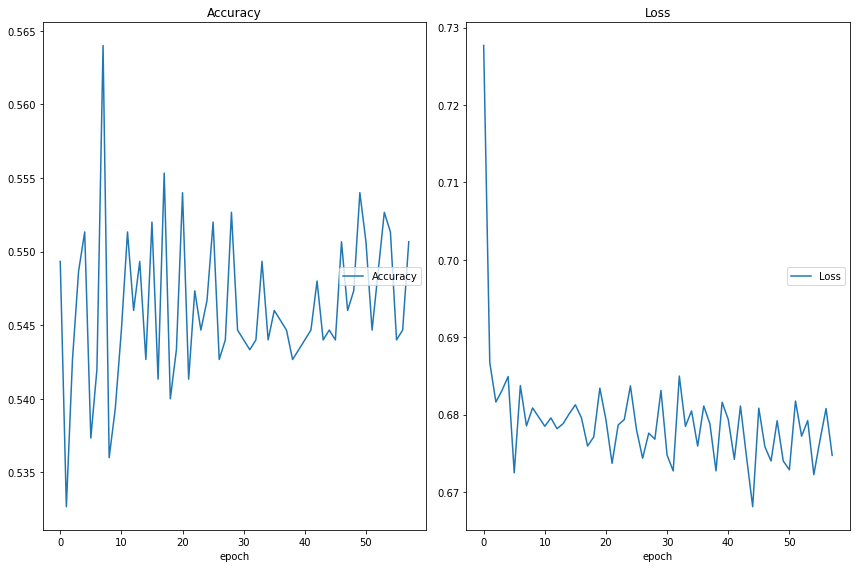

Accuracy
	Accuracy         	 (min:    0.533, max:    0.564, cur:    0.551)
Loss
	Loss             	 (min:    0.668, max:    0.728, cur:    0.675)


KeyboardInterrupt: 

In [83]:
losses = []
plotlosses = PlotLosses()
avg_loss_lr = 0.0
avg_accuracy = 0.0
for i in tnrange(N_EPOCHS):
    indices = np.random.choice(X_train.shape[0], SAMPLE_SIZE, replace=False)
    sample_x = X_train[indices]
    sample_y = Y_train[indices]
    avg_loss = 0.0
    for j in range(SAMPLE_SIZE):
        x = torch.Tensor(sample_x[j])
        target = torch.Tensor([int(sample_y[j])]).type(torch.LongTensor)
        optimizer.zero_grad()   
        output = model(x)
        output = output.reshape((1,2)).float()
        loss = criterion(output, target)
        avg_loss += float(loss)
        loss.backward()
        optimizer.step()
    avg_loss /= SAMPLE_SIZE
    avg_loss_lr += avg_loss
    #avg_accuracy += acc(X_test, Y_test)
    if i % N_DISPLAY == 0 and i > 0:
        avg_loss_lr /= N_DISPLAY
        #avg_accuracy /= N_DISPLAY
        plotlosses.update({"Loss": avg_loss_lr, "Accuracy": acc(X_test, Y_test)})
        plotlosses.send()
        avg_loss_lr = 0.0
        avg_accuracy = 0.0
    losses.append(avg_loss)

In [ ]:
plt.plot(ma_sampling(losses))
plt.show()

In [ ]:
print("Acc(train): %.3f"%acc(X_train, Y_train))
print("Acc(test): %.3f"%acc(X_test, Y_test))

As it can be seen neural networks are absolutely useless for classifying _~~anything~~_ elliptic curves.

## Naive Bayesian classifier

In [85]:
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
naive_bayes = GaussianNB()
naive_bayes.fit(X_train , Y_train)
Y_predicted = naive_bayes.predict(X_test)
print("Acc: %.3f" % metrics.accuracy_score(Y_predicted , Y_test))

Acc: 0.541


## Convolutional neural network

In [84]:
model = nn.Sequential(
        nn.Conv1d(1, 1, 64),
        nn.MaxPool1d(8),
        nn.LeakyReLU(),
        nn.Linear(145,290),
        nn.Tanh(),
        nn.Linear(290,145),
        nn.LeakyReLU(),
        nn.Linear(145,2)
)
x = torch.tensor(X_train[0], dtype=torch.double).float().reshape((1,1,1229))

RuntimeError: shape '[1, 1, 1229]' is invalid for input of size 1

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [ ]:
def acc(X,Y):
    err_cnt = 0
    correct_cnt = 0
    for i in range(len(X)):
        x = torch.tensor(X[i], dtype=torch.double).float().reshape((1,1,1229))
        y = Y[i]
        _y = model(x)
        if _y[0][0][0] > _y[0][0][1]:
            cls = 0
        else:
            cls = 1
        if round(y) != cls:
            err_cnt+=1
        else:
            correct_cnt+=1
    return correct_cnt/(correct_cnt+err_cnt)

In [ ]:
DATA_SIZE = len(X[0])
N_EPOCHS = 800
N_DISPLAY = 20
SAMPLE_SIZE = 100
losses = []
plotlosses = PlotLosses()
avg_loss_lr = 0.0
avg_accuracy = 0.0
for i in tnrange(N_EPOCHS):
    indices = np.random.choice(X_train.shape[0], SAMPLE_SIZE, replace=False)
    sample_x = X_train[indices]
    sample_y = Y_train[indices]
    avg_loss = 0.0
    for j in range(SAMPLE_SIZE):
        x = torch.Tensor(sample_x[j]).reshape((1,1,1229))
        target = torch.Tensor([int(sample_y[j])]).type(torch.LongTensor)
        optimizer.zero_grad()   
        output = model(x)
        output = output[0]
        loss = criterion(output, target)
        avg_loss += float(loss)
        loss.backward()
        optimizer.step()
    avg_loss /= SAMPLE_SIZE
    avg_loss_lr += avg_loss
    #avg_accuracy += acc(X_test, Y_test)
    if i % N_DISPLAY == 0 and i > 0:
        avg_loss_lr /= N_DISPLAY
        #avg_accuracy /= N_DISPLAY
        plotlosses.update({"Loss": avg_loss_lr, "Accuracy": acc(X_test, Y_test)})
        plotlosses.send()
        avg_loss_lr = 0.0
        avg_accuracy = 0.0
    losses.append(avg_loss)

In [ ]:
print("Acc(train): %.3f"%acc(X_train, Y_train))
print("Acc(test): %.3f"%acc(X_test, Y_test))

Is this magic of random intialization?...or convolutional networks really suitable for working with big vectors? Anyway, lets save this network:

In [ ]:
torch.save(model, "output/magic.th")

## Decision tree classifier


In [74]:
matplotlib.rc('figure', figsize=(20, 20))

In [75]:
model = tree.DecisionTreeClassifier()
model = model.fit(X_train, Y_train)

In [76]:
def acc(X,Y,fn):
    err_cnt = 0
    correct_cnt = 0
    for i in range(len(X)):
        x = X[i]
        y = Y[i]
        _y = fn([x])
        cls = _y[0]
        if round(y) != cls:
            err_cnt+=1
        else:
            correct_cnt+=1
    return correct_cnt/(correct_cnt+err_cnt)

In [77]:
accuracy = acc(X_test, Y_test, model.predict)
print("Accuracy:", accuracy)
print("N correct:%d/%d"%(round(len(X_test)*accuracy), len(X_test)))

Accuracy: 0.5104
N correct:1276/2500


In [78]:
tree.plot_tree(model)
plt.plot(figsize=(10,10))
plt.show()

KeyboardInterrupt: 

In [ ]:
r = tree.export_text(model)

In [ ]:
importances = list(model.feature_importances_)
for i in range(len(importances)):
    if importances[i] > 0.0:
        print(f"{indexes[i]} has importance {importances[i]}")

## Bootstrap
Lets build tree many(e.g. 20) times and see which features would be most important and whether corresponiding index is Sophie-Germain prime or safe prime.

In [ ]:
def bootstrap_best_feature():
    model = tree.DecisionTreeClassifier()
    model = model.fit(X_train, Y_train)
    importances = list(model.feature_importances_)
    best_feature_n = None
    best_score = 0.0
    for feature_n in range(len(importances)):
        if importances[feature_n] > best_score:
            best_score = importances[feature_n]
            best_feature_n = feature_n
    return best_feature_n, best_score

In [ ]:
best_coefs = []
best_trees = []
n = 1000
n_sg = 0
n_safe = 0
total_score = 0.0
for i in tnrange(n):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.5, shuffle = True)
    n_feature, score = bootstrap_best_feature()
    total_score += score
    prime = int(indexes[n_feature][1:])
    if is_sg(prime):
        n_sg += 1
    if is_safe(prime):
        n_safe += 1
    accuracy = acc(X_test, Y_test, model.predict)
    if accuracy == 1.0:
        best_trees.append(model)
    best_coefs.append(prime)
print(f"n_sg={n_sg}")
print(f"n_safe={n_safe}")
print(f"avg_score={total_score/n}")

In [ ]:
plt.hist(best_coefs)
plt.grid()
plt.show()

In [ ]:
plt.scatter(df["A71"], df["CM"])
plt.show()

In [ ]:
t = df[df["CM"]==0.0]

In [ ]:
plt.hist(t["A71"])
plt.show()

<p>We can see that only 8 curve are classified incorrectly: they are said to be CM while they are not. This is exactly why tree adds additional conditions. It would be quite intresting to note that value of some $a_p$ being equal $0$ also means that elliptic curve singular in field modulo $p$. So we can predict that using random forest of trees built on different splits may increase accuracy up to $100\%$.<p>
<p>Using previously obtained data we can note that there is some coefficient which are zero when curve has CM.</p> 

**Conjecture(strong)**:
<br>
There is an infinite subset of primes $C\subset P$, s.t. for any elliptic curve $E$:
$$
\displaystyle
\forall p\in C: a_p=0 \Rightarrow E\in CM
$$
* $a_p$ is coefficients of Hasse-Weil $L$-function for 
* $CM$ set of elliptic curves with $CM$

In [ ]:
is_sg(71)

## $L(E,1)$ 

As BSD conjecture suggests the elliptic curve rank can depend on $L$-function at point $1$.

In [ ]:
plt.scatter(df["CM"], df["L1"])
plt.show()

In [65]:
model = tree.DecisionTreeClassifier()
model = model.fit(X_train, Y_train)

In [66]:
accuracy = acc(X_test, Y_test, model.predict)
print("Accuracy:", accuracy)
print("N correct:%d/%d"%(round(len(X_test)*accuracy), len(X_test)))

Accuracy: 0.5104
N correct:1276/2500


In [67]:
X_test

array([[-6.17734769e-19],
       [ 1.50845420e+00],
       [ 0.00000000e+00],
       ...,
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [-4.89558470e-19]])